In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Trinomial Model ###
A binomial model suffers severely from issues of accuracy and convergence.

Similar to the binomial model, option prices can be computed using discounted expectation in a trinomial tree. 

The log of asset price in a recombinant (additive) trinomial tree can go up by $\Delta_{x}$, stay the same or go down by $\Delta_{x}$ with probabilities $p_{u}$, $p_{m}$ and $p_{d}$.

The choice of model parameters 

$$
\Delta_{x}=\sigma\sqrt{3\Delta_{t}}\\
p_{u}=\frac{1}{2}(s + a)\\
p_{m}=1-s\\
p_{d}=\frac{1}{2}(s - a)
$$

where
$$
s=\frac{\sigma^{2}\Delta_{t} + \nu^{2}\Delta_{t}^{2}}{\Delta_{x}^{2}}\\
a=\frac{\nu\Delta_{t}}{\Delta_{x}}\\
\nu=r-d-\frac{1}{2}\sigma^{2}
$$

The discounted expectation under risk-neutral probabilities at node $(i,j)$ is
$$
C_{i,j}=\exp{(-r\Delta_{t})}(p_{u}C_{i+1,j+1} + p_{m}C_{i+1,j} + p_{d}C_{i+1,j-1})
$$



In [7]:
def aTM_Euro(S0: float, K: float, r: float, sigma: float, div: float, T: float, Ntree: int, optype: str) -> list:
    '''
    S0: initial asset price
    K: strike price
    r: risk-free rate
    sigma: volatility
    div: continuous dividend yeild
    T: time to maturity
    Ntree: number of periods
    optype: option type ('call' or 'put')
    '''

    dt = T/Ntree
    sdt = np.sqrt(dt)
    dx = np.sqrt(3)*sigma*sdt

    dfact = np.exp(-r*dt) # discount factor

    nu = (r-div)-0.5*sigma**2
    sf = (sigma**2*dt + (nu*dt)**2)/dx**2
    af = nu*dt/dx

    # trinomial model probabilities
    pu = 0.5*(sf + af)
    pm = 1 - sf
    pd = 0.5*(sf - af)

    # parameter exception
    if ((0<r) and (0<sigma)):
        pass
    else:
        raise Exception('parameter values not allowed')
    
    #payoff matrix
    j0 = Ntree # centre index
    Pmat = np.zeros(shape=(2*Ntree+1,Ntree+1))
    Kmat = np.zeros(shape=(2*Ntree+1,Ntree+1))

    for t in range (Ntree+1): # asset price
        exponents = np.arange(-t, t+1)
        Pmat[j0-t:j0+(t+1), t] = S0*np.exp(dx*exponents[::-1])

        Kmat[j0-t:j0+(t+1), t] = K # strike    
    Pmat = Pmat-Kmat # payoffs

    if optype == 'call':
        Pmat[Pmat<0] = 0
        Pmat = Pmat
    elif optype == 'put':
        Pmat[Pmat>0] = 0
        Pmat = -Pmat
    else: raise Exception('optype must be call or put')

    # payoff at maturity T
    Vmat = np.zeros(shape=(2*Ntree+1,Ntree+1))
    Vmat[:,-1] = Pmat[:,-1]

    # backward step wise option price calculation
    for m, t in enumerate(range(Ntree-1,-1,-1)):
        Vmat[j0-t:j0+(t+1), t] = dfact*(pu*Vmat[m:2*Ntree-(m+1), t+1] + pm*Vmat[m+1:2*Ntree-m, t+1] + pd*Vmat[m+2:2*Ntree-(m-1), t+1]) # European option
    return (Vmat)   



In [8]:
price=aTM_Euro(S0=100, K=100, r=0.06, sigma=0.2, div=0.03, T=1, Ntree=3, optype='call')
print(np.around(price,3))

[[ 0.     0.     0.    82.212]
 [ 0.     0.    49.678 49.182]
 [ 0.    24.08  22.905 22.14 ]
 [ 8.425  6.415  3.801  0.   ]
 [ 0.     0.652  0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]]


In [76]:
def aTM_Amer(S0: float, K: float, r: float, sigma: float, div: float, T: float, Ntree: int, optype: str, exmat: bool=False) -> list:
    '''
    S0: initial asset price
    K: strike price
    r: risk-free rate
    sigma: volatility
    div: continuous dividend yeild
    T: time to maturity
    Ntree: number of periods
    optype: option type ('call' or 'put')
    exmat: show early exercise
    '''

    dt = T/Ntree
    sdt = np.sqrt(dt)
    dx = np.sqrt(3)*sigma*sdt

    dfact = np.exp(-r*dt) # discount factor

    nu = (r-div)-0.5*sigma**2
    sf = (sigma**2*dt + (nu*dt)**2)/dx**2
    af = nu*dt/dx

    # trinomial model probabilities
    pu = 0.5*(sf + af)
    pm = 1 - sf
    pd = 0.5*(sf - af)

    # parameter exception
    if ((0<r) and (0<sigma)):
        pass
    else:
        raise Exception('parameter values not allowed')
    
    #payoff matrix
    j0 = Ntree # centre index
    Pmat = np.zeros(shape=(2*Ntree+1,Ntree+1))
    Kmat = np.zeros(shape=(2*Ntree+1,Ntree+1))

    for t in range (Ntree+1): # asset price
        exponents = np.arange(-t, t+1)
        Pmat[j0-t:j0+(t+1), t] = S0*np.exp(dx*exponents[::-1])

        Kmat[j0-t:j0+(t+1), t] = K # strike    
    Pmat = Pmat-Kmat # payoffs

    if optype == 'call':
        Pmat[Pmat<0] = 0
        Pmat = Pmat
    elif optype == 'put':
        Pmat[Pmat>0] = 0
        Pmat = -Pmat
    else: raise Exception('optype must be call or put')

    # payoff at maturity T
    Vmat = np.zeros(shape=(2*Ntree+1,Ntree+1))
    Vmat[:,-1] = Pmat[:,-1]

    # backward step wise option price calculation
    if exmat == True:
        Exmat = np.zeros(shape=(2*Ntree+1,Ntree+1))
        for m, t in enumerate(range(Ntree-1,-1,-1)):
            Vmat[j0-t:j0+(t+1), t] = np.maximum(dfact*(pu*Vmat[m:2*Ntree-(m+1), t+1] + pm*Vmat[m+1:2*Ntree-m, t+1] + pd*Vmat[m+2:2*Ntree-(m-1), t+1]), Pmat[j0-t:j0+(t+1), t]) # American option
            Exmat[j0-t:j0+(t+1), t] = (dfact*(pu*Vmat[m:2*Ntree-(m+1), t+1] + pm*Vmat[m+1:2*Ntree-m, t+1] + pd*Vmat[m+2:2*Ntree-(m-1), t+1]) - Pmat[j0-t:j0+(t+1), t])<0 # early exercise
        plt.matshow(Exmat, cmap=plt.cm.YlGn, aspect=0.5 )
        plt.title('Early exercise')
    if exmat == False:
        for m, t in enumerate(range(Ntree-1,-1,-1)):
            Vmat[j0-t:j0+(t+1), t] = np.maximum(dfact*(pu*Vmat[m:2*Ntree-(m+1), t+1] + pm*Vmat[m+1:2*Ntree-m, t+1] + pd*Vmat[m+2:2*Ntree-(m-1), t+1]), Pmat[j0-t:j0+(t+1), t]) # American option

    return (Vmat) 



[[ 0.     0.     0.    -0.   ]
 [ 0.     0.    -0.    -0.   ]
 [ 0.     0.437 -0.    -0.   ]
 [ 5.931  4.655  2.816 -0.   ]
 [ 0.    18.127 18.127 18.127]
 [ 0.     0.    32.968 32.968]
 [ 0.     0.     0.    45.119]]


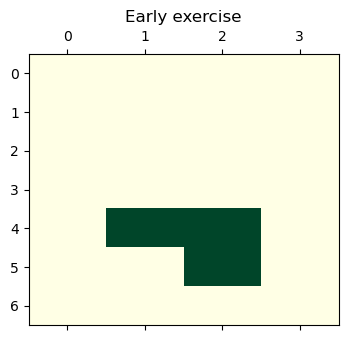

In [95]:
price=aTM_Amer(S0=100, K=100, r=0.06, sigma=0.2, div=0.03, T=1,Ntree=3, optype='put', exmat=True)
print(np.around(price,3))